In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
from collections import Counter, defaultdict
import plotly.graph_objects as go
import re
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("/content/extracted_product_info_amazon.csv")

In [3]:
df.shape

(947, 7)

In [4]:
df.head()

,Title,Brand,Screen Size,Resolution,Aspect Ratio,Rating,Price
0,"acer SB240Y G0bi 23.8"" IPS Full HD Ultra-Slim ...",acer,23.8 Inches,FHD 1080p,16:9,4.4,94.99
1,"acer Nitro 31.5"" FHD 1920 x 1080 1500R Curved ...",acer,31.5 Inches,FHD 1080p,16:9,4.6,259.99
2,"Acer SB272 EBI 27"" Full HD (1920 x 1080) IPS Z...",acer,27 Inches,FHD 1080p,16:9,4.5,99.99
3,Sceptre 30-inch Curved Gaming Monitor 21:9 256...,Sceptre,30 Inches,FHD 1080p Ultra Wide,21:9,4.5,199.97
4,"SAMSUNG 32"" UJ59 Series 4K UHD (3840x2160) Com...",SAMSUNG,31.5 Inches,4K UHD 2160p,16:9,4.3,279.99


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         947 non-null    object
 1   Brand         947 non-null    object
 2   Screen Size   947 non-null    object
 3   Resolution    947 non-null    object
 4   Aspect Ratio  947 non-null    object
 5   Rating        947 non-null    object
 6   Price         947 non-null    object
dtypes: object(7)
memory usage: 51.9+ KB


In [6]:
df.describe()

,Title,Brand,Screen Size,Resolution,Aspect Ratio,Rating,Price
count,947,947,947,947,947,947,947
unique,296,62,57,41,16,25,166
top,"ASUS 31.5” 1080P Monitor (VA329HE) - Full HD, ...",acer,27 Inches,FHD 1080p,16:9,4.6,199.99
freq,84,532,260,566,833,368,122


# Feature engineering and data cleanup
There are columns with too much variability like resolution. We separate the data in this column into other columns and engineer new features to get more meaningful and easily understandable and comparable data

In [7]:
# Change column names for convenience
df.columns = ['title', 'brand', 'screen_size', 'resolution', 'aspect_ratio', 'rating', 'price']

In [8]:
# Values like '1,190.99' (with commas) make the column string type
df['price'] = df['price'].str.replace(',', '').astype(float)
df['price'].describe()

,price
count,947.000000
mean,215.636199
std,204.684089
min,7.340000
25%,99.990000
50%,157.990000
75%,259.990000
max,3809.000000


In [9]:
df['rating'].unique()

array(['4.4', '4.6', '4.5', '4.3', '4.1', '4.7', '4.2', '4.8', '3.9',
       '5.0', '4.0', '3.8', '3.6', '3.3', 'Previous', '3.4', '3.7', '3.5',
       '2.2', '3.0', '5', '1.0', '3.1', '2.0', '3.2'], dtype=object)

In [10]:
# Get rows before the row with rating value = "previous"
print(df[df['rating']=='Previous'].shape)

(35, 7)


In [11]:
# We remove rows with aspect_ratio = Unknown and rating = Previous and analyze them separately later
df_excluded = df[(df['rating']=='Previous')]
df = df[df['rating']!='Previous']

In [12]:
df['resolution'].unique()

array(['FHD 1080p', 'FHD 1080p Ultra Wide', '4K UHD 2160p',
       'QHD Ultra Wide 1440p', 'QHD Wide 1440p', '5K QHD 1440p',
       '5K2K WUHD', 'Full HD (1080p) 1920 x 1080', '4K HDR 2016',
       'Quantom Dot OLED', 'QHD HDR400', 'FHD 1080i', 'UXGA Wide',
       '2K DCI 1080p', '4K UHD 1600p Ultra Wide', 'QXGA Wide', 'Full HD',
       '3840 x 2160 UHD', 'XGA Wide', '3440 x 1440 (UWQHD)', 'HD', 'SXGA',
       '640 x 480 pixels', '4K DCI 2160p', 'SVGA',
       'FHD 1080p Ultra Wide, FHD 1080p', 'XGA+ Wide', 'XGA', 'SVGA Wide',
       '4K UHD', 'SXGA+ Wide', 'VGA', '5K UHD 2160p Ultra Wide',
       '480 x 272', 'HD, FHD 1080p'], dtype=object)

In [13]:
# Separate features from resolution column into features like resolution: (4k, 1080p, ...),
# wide: True/False, ultra_wide: True/False, FHD, UHD etc
resolution_words = list(df['resolution'].str.replace(
    r'[,\(\)]', ' ', regex=True).str.split().explode())
print(set(resolution_words))

{'1440p', 'OLED', '1080i', '2160p', 'WUHD', 'x', 'Wide', 'XGA', '4K', 'FHD', 'Quantom', 'DCI', '5K2K', '1440', 'UHD', '1600p', '1920', '3840', 'QHD', 'SXGA', '3440', '2160', '640', 'Dot', '2016', 'HD', 'UWQHD', '5K', '2K', '1080p', 'pixels', 'SVGA', 'Ultra', 'Full', '272', 'XGA+', 'SXGA+', 'QXGA', 'UXGA', '480', 'VGA', 'HDR', '1080', 'HDR400'}


In [14]:
print(len(set(list(df['resolution'] + ' ' + df['aspect_ratio']))))
print(set(list(df['resolution'] + ' ' + df['aspect_ratio'])))

56
{'5K QHD 1440p 21:9', 'XGA+ Wide Unknown', '4K HDR 2016 16:9', 'FHD 1080p Unknown', 'QHD Wide 1440p 21:9', '4K UHD 2160p 17:9', 'QHD Ultra Wide 1440p 32:9', 'VGA 16:9', '4K DCI 2160p 16:9', '4K UHD 16:9', 'QXGA Wide 16:9', 'HD 16:9', '2K DCI 1080p 16:9', 'UXGA Wide 16:9', 'FHD 1080p 1.27:1', 'SXGA 4:3', '640 x 480 pixels 1.38:1', 'VGA 16:10', '480 x 272 1.76:1', 'QHD Ultra Wide 1440p 21:9', 'QHD Ultra Wide 1440p 2.35:1', 'XGA 16:9', 'FHD 1080p Ultra Wide, FHD 1080p 21:9', '5K UHD 2160p Ultra Wide 21:9', 'Quantom Dot OLED 21:9', 'XGA Wide 16:10', 'Full HD 16:9', 'HD 16:10', 'HD, FHD 1080p 16:9', '4K UHD 1600p Ultra Wide 16:9', 'SVGA 16:9', '3840 x 2160 UHD 16:9', 'FHD 1080p 1.78:1', 'QHD Ultra Wide 1440p 16:9', 'QHD Wide 1440p 16:9', '3440 x 1440 (UWQHD) 16:9', 'SVGA Wide 16:9', '4K UHD 2160p 16:9', 'FHD 1080i 16:9', 'VGA 4:3', 'FHD 1080p Ultra Wide 16:9', '5K QHD 1440p 32:9', '5K2K WUHD 21:9', 'QHD HDR400 16:9', 'QHD Wide 1440p 2.30:1', 'FHD 1080p 1.77:1', 'QHD Wide 1440p 16:10', 'S

In [15]:
df['aspect_ratio'] = df["aspect_ratio"].replace('16∶9', '16:9')

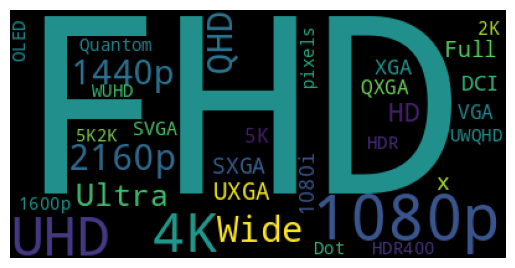

In [16]:
# We can get an idea of unique keywords and their frequency in the combined resolution column using a wordcloud
wordcloud = WordCloud().generate(" ".join(resolution_words))

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="black",
                      collocations=False,
                      max_words=len(resolution_words),
                      max_font_size=200,
                      relative_scaling=0.2).generate(" ".join(resolution_words))

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
resolution_standard_info_dfs = pd.read_html("https://en.wikipedia.org/wiki/Display_resolution_standards")

In [18]:
df_standard_res = resolution_standard_info_dfs[0].copy()
df_standard_res.columns = resolution_standard_info_dfs[0].columns.get_level_values(1)
df_standard_res = df_standard_res.replace(r'[\(\)]', '', regex=True)
df_standard_res.replace(r'[\\\/\≈,]', ' ', regex=True, inplace=True)
df_standard_res.replace(r'\s+', ' ', regex=True, inplace=True)
df_standard_res.head(3)

,Height (px),5∶4 (1.25),4∶3 (1.3),15∶10 (1.5),16∶10 (1.6 ≈ φ),15∶9 (1.6),16∶9 (1.775–1.8),18∶9 (2.0–2.2),21∶9 (2.3–2.4),Unnamed: 9_level_1
0,120.0,NaN,160 QQVGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,160.0,NaN,NaN,240 HQVGA,NaN,NaN,NaN,NaN,NaN,NaN
2,240.0,NaN,320 QVGA,360 WQVGA,384 WQVGA,400 WQVGA,432 FWQVGA 9∶5,NaN,NaN,NaN


In [19]:
df_standard_res.set_index("Height (px)", drop=True, inplace=True)

In [20]:
width_dict = defaultdict(list)
width_groups = []
for height, row in df_standard_res.iterrows():
    aspect_ratio_width_map = dict(row.dropna().items())
    # For every cell, separate specific aspect ratio, alphabetical representation and numeric pixel width using regex
    for standard_aspect_ratio, width in aspect_ratio_width_map.items():
        # As shown in the table, some aspect ratios are a range, precise ones are in the cell
        aspect_ratios = re.findall(r'\d{1,2}\.?\d:\d{1,2}', width)
        widths = [width]
        if len(aspect_ratios) != 0:
            widths = re.split("|".join(aspect_ratios), width)
            widths = [i.strip() for i in widths if len(i)>0]
        else:
            aspect_ratios = [standard_aspect_ratio.split()[0]]
        for width, aspect_ratio in zip(widths, aspect_ratios):
            pixel_widths = re.findall(r'\d{3,5}', width)
            string_identifier = re.findall(r'((\dK)?\ ?[A-Z]+[\+\-]?)', width.upper())
            string_identifier = [[i.strip() for i in j if len(i)>0] for j in string_identifier]
            string_identifier = [sorted(i, key=lambda x: len(x))[-1] for i in string_identifier if len(i) > 0]
            string_identifier = sorted(string_identifier, key=lambda x: len(x), reverse=True)
            width_identifier = "Ultra-wide" if "ultrawide" in width.lower().replace(
                " ", "") or "uw" in width.lower() else "Wide" if "wide" in width.lower(
                ) or "w" in width.lower() else "Not provided"
            if len(pixel_widths) == 0:
                continue
            if len(string_identifier) == 0:
                string_identifier = pixel_widths[0]
            else:
                string_identifier = string_identifier[0]
            width_dict[string_identifier].extend(pixel_widths)
            for pixel_width in pixel_widths:
                width_groups.append({
                    "standard_aspect_ratio": standard_aspect_ratio.split()[0].strip(),
                    "width": pixel_width,
                    "height": str(int(height)),
                    "string_identifier": string_identifier,
                    "precise_aspect_ratio": aspect_ratio.strip(),
                    "standard_width": df_standard_res.iloc[-1][standard_aspect_ratio],
                    "width_identifier": width_identifier
                })
width_groups_df = pd.DataFrame(width_groups)

width_dict = dict(width_dict)
print(width_dict)

{'QQVGA': ['160'], 'HQVGA': ['240'], 'QVGA': ['320'], 'WQVGA': ['360', '384', '400'], 'FWQVGA': ['432'], 'HVGA': ['480'], 'NHD': ['640'], 'VGA': ['640'], 'WVGA': ['720', '768', '800'], 'FWVGA': ['848', '854', '960'], 'QHD': ['960'], 'PAL': ['768'], 'WSVGA': ['1024', '1024', '1024'], 'SVGA': ['800'], 'DVGA': ['960'], '1136': ['1136'], '960': ['960'], 'HD': ['1280'], 'XGA': ['1024'], 'WXGA': ['1152', '1280', '1280'], 'FWXGA': ['1360', '1366'], 'XGA+': ['1152'], 'WXGA+': ['1280', '1440'], 'HD+': ['1600'], 'SXGA': ['1280', '1280'], 'FWXGA+': ['1440'], 'DXGA': ['1536'], 'WSXGA': ['1600'], 'SXGA+': ['1400'], 'WSXGA+': ['1680'], '1280': ['1280'], '1440': ['1440'], 'FHD': ['1920'], '2160': ['2160', '2280', '2340'], 'UWFHD': ['2520', '2560'], 'QWXGA': ['2048'], 'UXGA': ['1600'], 'WUXGA': ['1920'], 'FHD+': ['2160'], 'WQHD': ['2560'], '2880': ['2880', '2960', '3040'], 'UWQHD': ['3120', '3200', '3440'], 'QXGA': ['2048'], 'WQXGA': ['2560'], 'K': ['2880', '5120', '10240'], 'WQXGA+': ['2880'], 'QHD+'

In [21]:
width_groups_df.head()

,standard_aspect_ratio,width,height,string_identifier,precise_aspect_ratio,standard_width,width_identifier
0,4∶3,160,120,QQVGA,4∶3,Classic,Not provided
1,15∶10,240,160,HQVGA,15∶10,Wide,Not provided
2,4∶3,320,240,QVGA,4∶3,Classic,Not provided
3,15∶10,360,240,WQVGA,15∶10,Wide,Wide
4,16∶10,384,240,WQVGA,16∶10,Wide,Wide


In [22]:
width_groups_df[width_groups_df["string_identifier"].str.contains("")]

,standard_aspect_ratio,width,height,string_identifier,precise_aspect_ratio,standard_width,width_identifier
0,4∶3,160,120,QQVGA,4∶3,Classic,Not provided
1,15∶10,240,160,HQVGA,15∶10,Wide,Not provided
2,4∶3,320,240,QVGA,4∶3,Classic,Not provided
3,15∶10,360,240,WQVGA,15∶10,Wide,Wide
4,16∶10,384,240,WQVGA,16∶10,Wide,Wide
...,...,...,...,...,...,...,...
72,4∶3,3200,2400,QUXGA,4∶3,Classic,Not provided
73,16∶10,3840,2400,WQUXGA,16∶10,Wide,Wide
74,16∶9,5120,2880,K,16∶9,Wide,Not provided
75,16∶9,7680,4320,8K UHD,16∶9,Wide,Not provided


In [23]:
normalized_resolution_features = [
    'standard_aspect_ratio', 'width', 'height', 'string_identifier',
    'precise_aspect_ratio', 'standard_width', 'width_identifier'
]
def map_to_standard(text):
    if "full hd" in text.lower():
        text = text.lower().replace("full hd", "FHD")
    pixel_widths = re.findall(r'\d{3,5}', text)
    identifier_text = text.lower().replace("ultra", "").replace("wide", "").replace("ultrawide", "")
    string_identifier = re.findall(r'((\dK)?\ ?[A-Z]+[\+\-]?)', identifier_text.upper())
    string_identifier = [[i.strip() for i in j if len(i)>0] for j in string_identifier]
    string_identifier = [sorted(i, key=lambda x: len(x))[-1] for i in string_identifier if len(i) > 0]
    string_identifier = sorted(string_identifier, key=lambda x: len(x), reverse=True)

    # print(string_identifier)
    if len(string_identifier) > 0:
        string_identifier = string_identifier[0]
    else:
        string_identifier = None

    for width in pixel_widths:
        if not string_identifier:
            string_identifier = str(width)
        possible_prefixes = []
        if string_identifier not in width_dict:
            if "ultra" in text.lower() and "wide" in text.lower():
                possible_prefixes.append("UW")
        elif "wide" in text.lower():
            possible_prefixes.append("W")
        possible_prefixes.append("")
        possible_identifiers = [prefix + string_identifier for prefix in possible_prefixes]
        matching_standard_record = width_groups_df[
            (width_groups_df['width'] == width)
            & (width_groups_df["string_identifier"].isin(possible_identifiers))]

        if not matching_standard_record.empty:
            return matching_standard_record.iloc[0]

        # If width not matched, the given measurement is height
        matching_standard_record = width_groups_df[
            (width_groups_df['height'] == width)
            & (width_groups_df["string_identifier"].isin(possible_identifiers))]
        if not matching_standard_record.empty:
            return matching_standard_record.iloc[0]

        # If both height and width not present, match based on identifier
        matching_standard_record = width_groups_df[
            (width_groups_df["string_identifier"] == string_identifier)]
        if not matching_standard_record.empty:
            return matching_standard_record.iloc[0]
    if len(pixel_widths) == 0:
        matching_standard_record = width_groups_df[
            (width_groups_df["string_identifier"] == string_identifier)]
        if not matching_standard_record.empty:
            return matching_standard_record.iloc[0]

    return pd.Series([np.nan]*7, index=normalized_resolution_features)


In [24]:
# Add columns for the features extracted from resolution column to the main dataframe
df[normalized_resolution_features] = df['resolution'].apply(map_to_standard)

In [25]:
print(df[df["standard_aspect_ratio"].isna()]["resolution"].shape)
df[df["standard_aspect_ratio"].isna()]["resolution"].unique(), len(df[df["standard_aspect_ratio"].isna()]["resolution"].unique())

(13,)


(array(['5K QHD 1440p', '5K2K WUHD', '4K HDR 2016', 'Quantom Dot OLED',
        '2K DCI 1080p', '3840 x 2160 UHD', '640 x 480 pixels',
        '4K DCI 2160p', '5K UHD 2160p Ultra Wide', '480 x 272'],
       dtype=object),
 10)

In [26]:
# Some of these values are incorrect, not in the standard data table or written differently.
# We can map these manually, but as
new_mappings = {
    '5K QHD 1440p': {"width": 5120, "height": 1440, "standard_width": "Ultra-wide", "standard_aspect_ratio": "3.56:1"},
    '5K2K WUHD': {"width": 5120, "height": 2160, "standard_width": "Ultra-wide", "standard_aspect_ratio": "21:9"},
    '4K HDR 2016': {"width": 3840, "height": 2160, "standard_width": "Wide", "standard_aspect_ratio": "16:9"},
    '2K DCI 1080p': {"width": 2160, "height": 1080, "standard_width": "Ultra-wide", "standard_aspect_ratio": "2:1"},
    '3840 x 2160 UHD': {"width": 3840, "height": 2160, "standard_width": "Wide", "standard_aspect_ratio": "16:9"},
    '640 x 480 pixels': {"width": 640, "height": 480, "standard_width": "Classic", "standard_aspect_ratio": "4:3"},
    '4K DCI 2160p': {"width": 3840, "height": 2160, "standard_width": "Wide", "standard_aspect_ratio": "16:9"},
    '5K UHD 2160p Ultra Wide': {"width": 5120, "height": 2160, "standard_width": "Ultra-wide", "standard_aspect_ratio": "21:9"},
    '480 x 272': {"width": 480, "height": 272, "standard_width": "Classic", "standard_aspect_ratio": "1.76:1"},
}
# Drop Quantom Dot OLED
df = df[df["resolution"] != "Quantom Dot OLED"]
# Map columns of other columns from new_mappings dict based on resolution
for key, value in new_mappings.items():
    df.loc[df["resolution"]==key] = df[df["resolution"]==key].fillna(value)

In [27]:
# the : in 1st string is U+2236
df['standard_aspect_ratio'] = df['standard_aspect_ratio'].replace('16∶9', '16:9')
df['precise_aspect_ratio'] = df['precise_aspect_ratio'].replace('16∶9', '16:9')
df['aspect_ratio'] = df['aspect_ratio'].replace('16∶9', '16:9')

In [28]:
# df[df["resolution"]=="480 x 272"].fillna({"width": 480, "height": 272, "standard_width": "Classic"})
# df[df.fillna(new_mappings)["precise_aspect_ratio"].isna()]
df["precise_aspect_ratio"].fillna(df["standard_aspect_ratio"], inplace=True)
df["width_identifier"].fillna("Not provided", inplace=True)
df["string_identifier"].fillna("", inplace=True)

In [29]:
# Convert the screen_size column to float by removing the units (all are in inches)
df["screen_size"] = df["screen_size"].str.replace(r"[^\d\.]", "", regex=True).astype(float)

In [31]:
# Convert width, height to int, standardize brandname by converting it to lowercase
df["width"] = df["width"].astype(int)
df["height"] = df["height"].astype(int)
df["brand"] = df["brand"].str.lower()

In [32]:
df["rating"] = df["rating"].astype(float)

In [33]:
df.loc[df['aspect_ratio']=='Unknown', 'aspect_ratio'] = df[df['aspect_ratio']=='Unknown']['standard_aspect_ratio']

In [34]:
# We add PPI (Pixels per inch) as it is a good descriptor for quality
df["ppi"] = df["width"] * df["height"] / df["screen_size"]

# For analysis, we convert ppi to integer and keep only some of the most significant powers of 10
df['ppi'] = (df["ppi"]//1000).astype(int)

# Analysis

In [35]:
df.head()

,title,brand,screen_size,resolution,aspect_ratio,rating,price,standard_aspect_ratio,width,height,string_identifier,precise_aspect_ratio,standard_width,width_identifier,ppi
0,"acer SB240Y G0bi 23.8"" IPS Full HD Ultra-Slim ...",acer,23.8,FHD 1080p,16:9,4.4,94.99,16:9,1920,1080,FHD,16:9,Wide,Not provided,87
1,"acer Nitro 31.5"" FHD 1920 x 1080 1500R Curved ...",acer,31.5,FHD 1080p,16:9,4.6,259.99,16:9,1920,1080,FHD,16:9,Wide,Not provided,65
2,"Acer SB272 EBI 27"" Full HD (1920 x 1080) IPS Z...",acer,27.0,FHD 1080p,16:9,4.5,99.99,16:9,1920,1080,FHD,16:9,Wide,Not provided,76
3,Sceptre 30-inch Curved Gaming Monitor 21:9 256...,sceptre,30.0,FHD 1080p Ultra Wide,21:9,4.5,199.97,16:9,1920,1080,FHD,16:9,Wide,Not provided,69
4,"SAMSUNG 32"" UJ59 Series 4K UHD (3840x2160) Com...",samsung,31.5,4K UHD 2160p,16:9,4.3,279.99,16:9,3840,2160,4K UHD,16:9,Wide,Not provided,263


In [36]:
df.shape

(911, 15)

In [37]:
df.describe()

,screen_size,rating,price,width,height,ppi
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,27.985950,4.450165,210.300143,2356.715697,1326.430296,125.425906
std,6.102003,0.287348,194.827752,778.967588,421.658879,122.043681
min,3.150000,1.000000,7.340000,480.000000,272.000000,9.000000
25%,24.500000,4.400000,99.990000,1920.000000,1080.000000,76.000000
50%,27.000000,4.500000,157.990000,1920.000000,1080.000000,87.000000
75%,31.500000,4.600000,249.990000,2560.000000,1440.000000,123.000000
max,86.000000,5.000000,3809.000000,5120.000000,2160.000000,2633.000000


In [38]:
df[[i for i in df.columns if df[i].dtype in ["str", "object"]]].describe()

,title,brand,resolution,aspect_ratio,standard_aspect_ratio,string_identifier,precise_aspect_ratio,standard_width,width_identifier
count,911,911,911,911,911,911,911,911,911
unique,260,55,34,14,8,15,8,3,3
top,"ASUS 31.5” 1080P Monitor (VA329HE) - Full HD, ...",acer,FHD 1080p,16:9,16:9,FHD,16:9,Wide,Not provided
freq,84,528,560,811,879,574,879,879,775


## Univariate Analysis

In [39]:
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32', 'float', 'int']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [40]:
# Colours to use
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a']

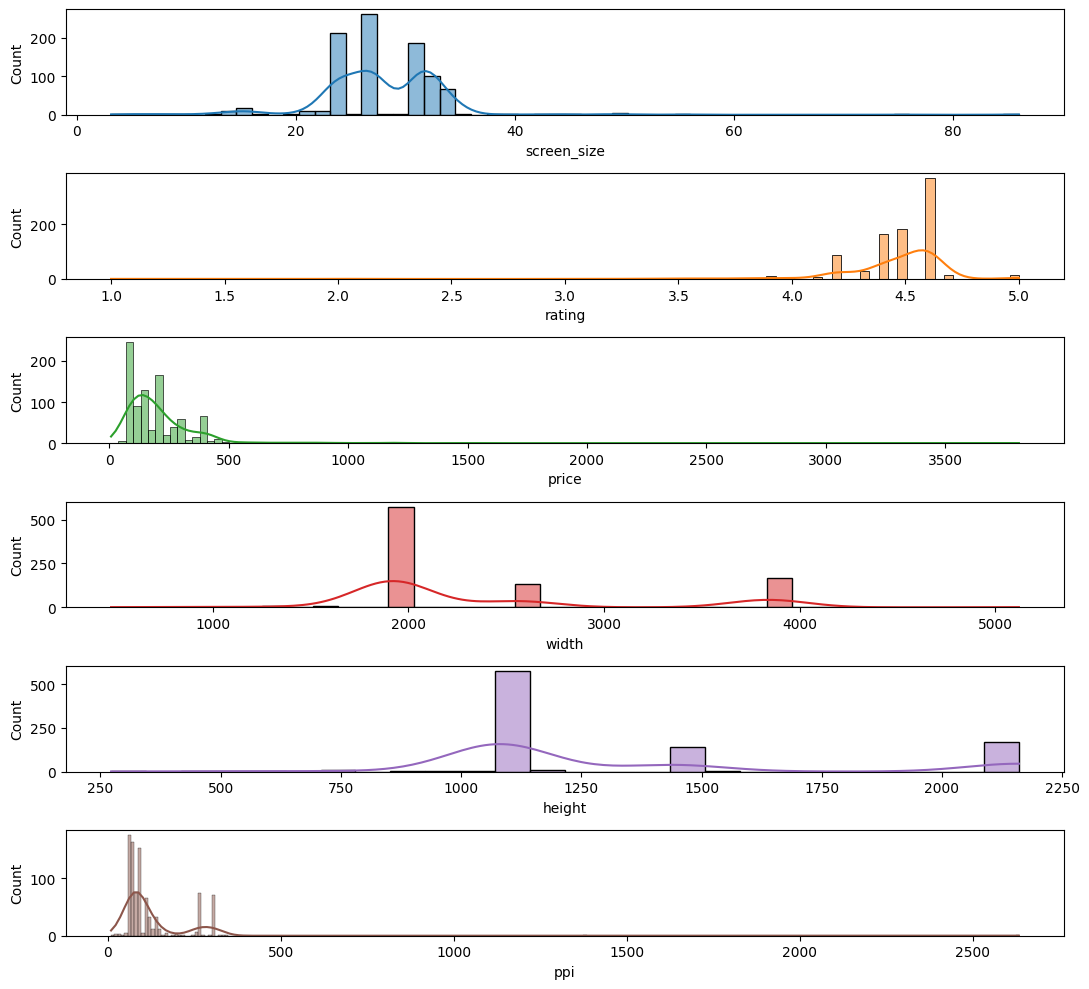

In [41]:
# Displot in subplots with different colors
fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(11, 10))
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, color=colors[i], ax=ax[i], kde=True)
plt.tight_layout()
plt.show()

Screensize and ppi show a bi-modal distribution (2 peaks), height and width have 3 peaks

All ratings are towards the higher end (left skewed) and mostly around 4.5

----------------------------------------------------

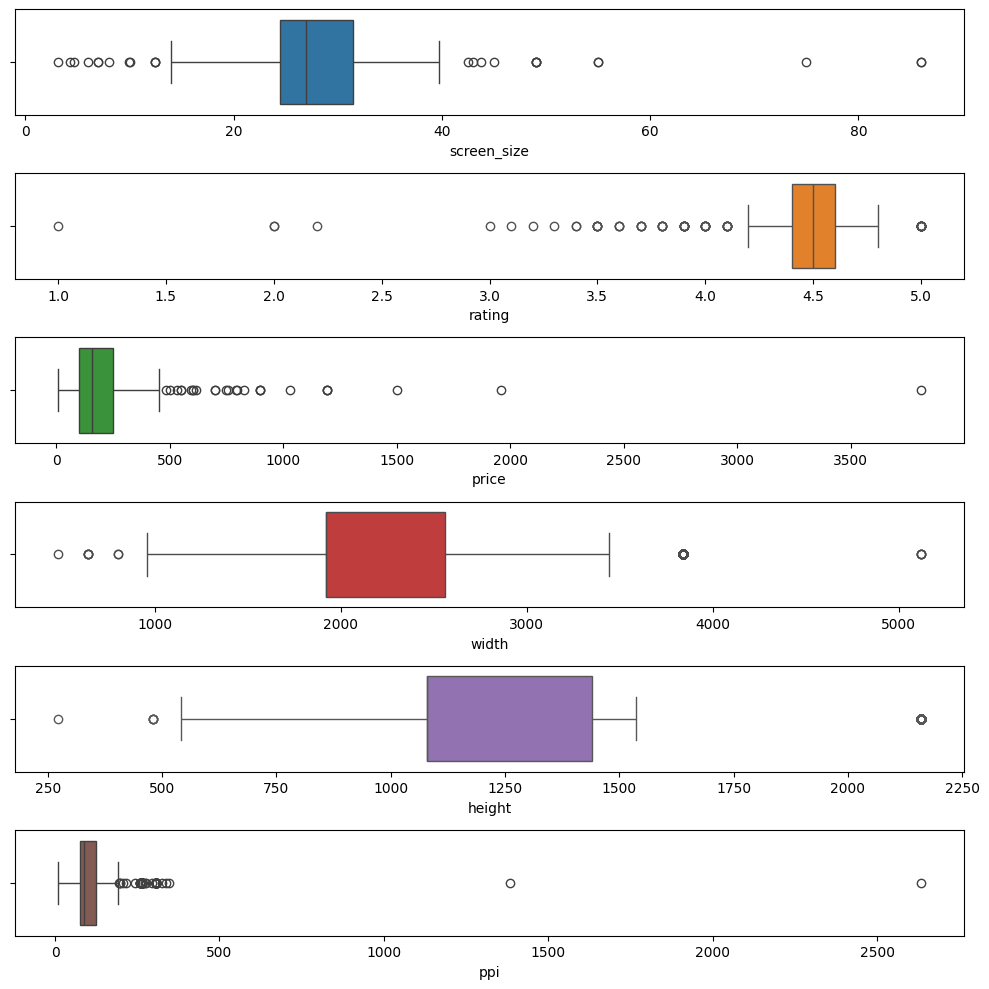

In [42]:
# sns boxplot with individual axes for each column
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=ax[i], color=colors[i])
plt.tight_layout()
plt.show()

For height and width, median is same as first quartile (Q1)

some monitors have exceptionally high PPI

----------------------------------------------------

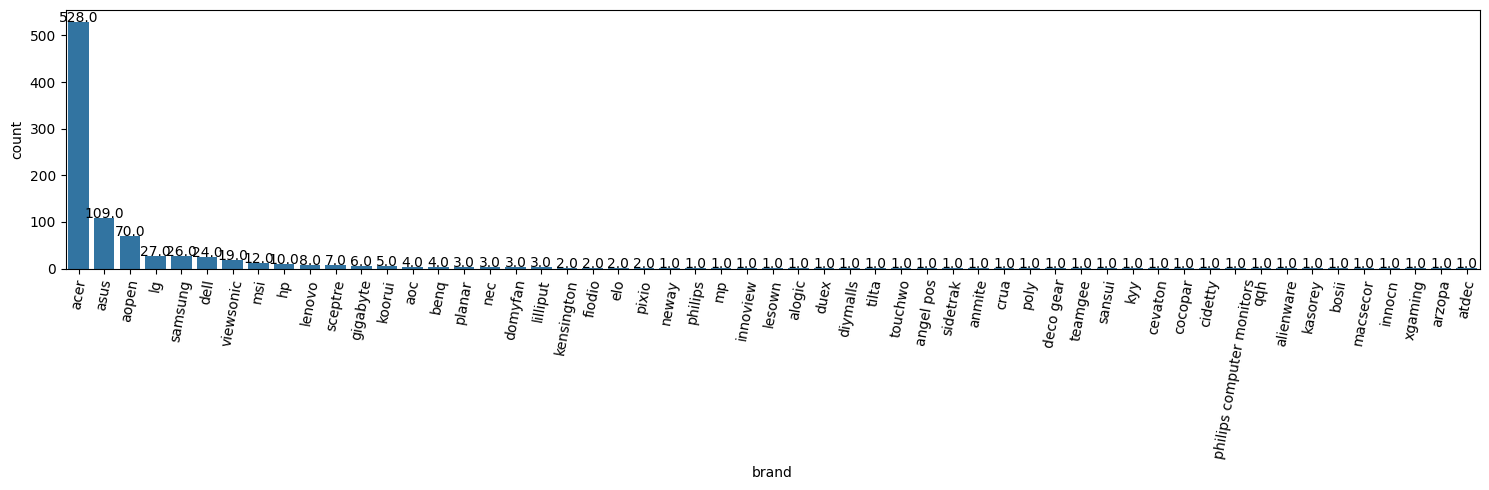

In [43]:
# Barplots to show count of brand in data
fig, ax = plt.subplots(figsize=(15, 5))
order = df['brand'].value_counts().index
graph = sns.countplot(data=df, x='brand', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
_ = plt.xticks(rotation=80)
plt.tight_layout()

Most of the brands only have one record

----------------------------------------------------

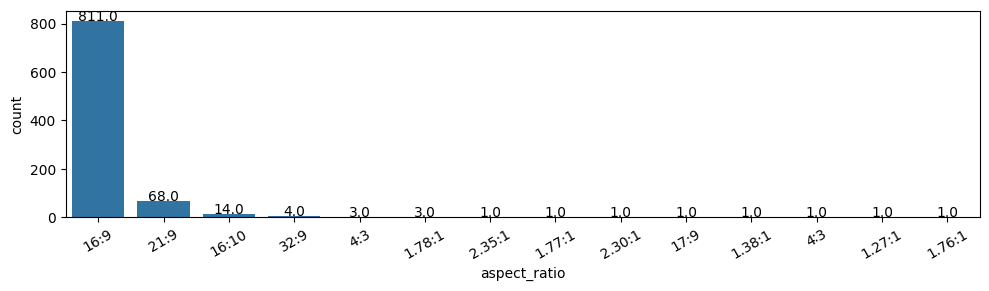

In [44]:
# Barplots to show count of unique aspect ratios already provided in data
fig, ax = plt.subplots(figsize=(10, 3))
order = df['aspect_ratio'].value_counts().index
graph = sns.countplot(data=df, x='aspect_ratio', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
_ = plt.xticks(rotation=30)
plt.tight_layout()

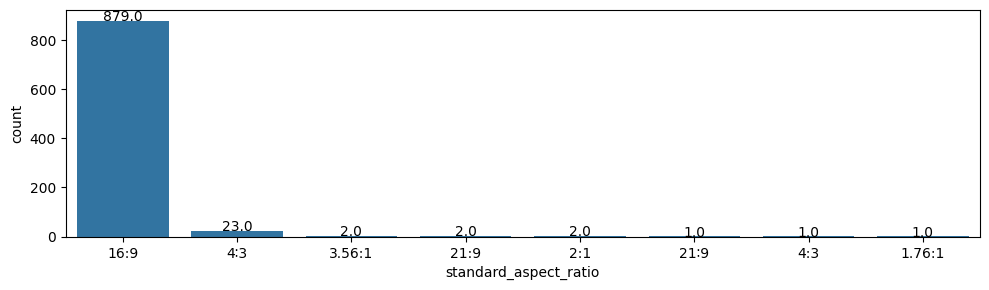

In [45]:
# Barplots to show count of unique standard aspect ratios we extracted in data
fig, ax = plt.subplots(figsize=(10, 3))
order = df['standard_aspect_ratio'].value_counts().index
graph = sns.countplot(data=df, x='standard_aspect_ratio', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
# _ = plt.xticks(rotation=80)
plt.tight_layout()

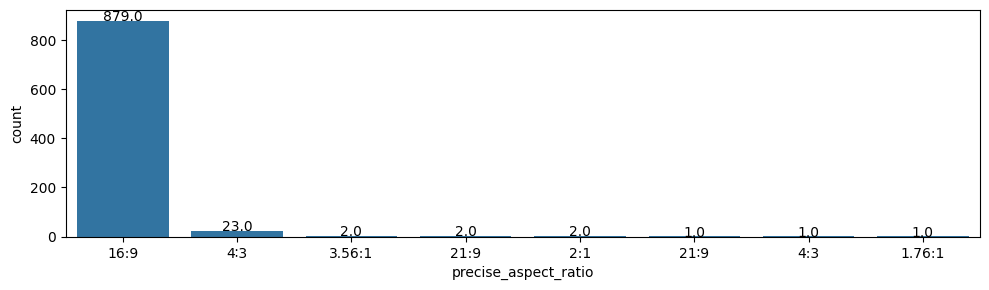

In [46]:
# Barplots to show count of precise aspect ratios we extracted in data
fig, ax = plt.subplots(figsize=(10, 3))
order = df['precise_aspect_ratio'].value_counts().index
graph = sns.countplot(data=df, x='precise_aspect_ratio', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
# _ = plt.xticks(rotation=80)
plt.tight_layout()

From all data retrieved from standard table and mentioned in the dataset,

we can see that 16:9 is the most common aspect ratio, followed by 4:3

----------------------------------------------------

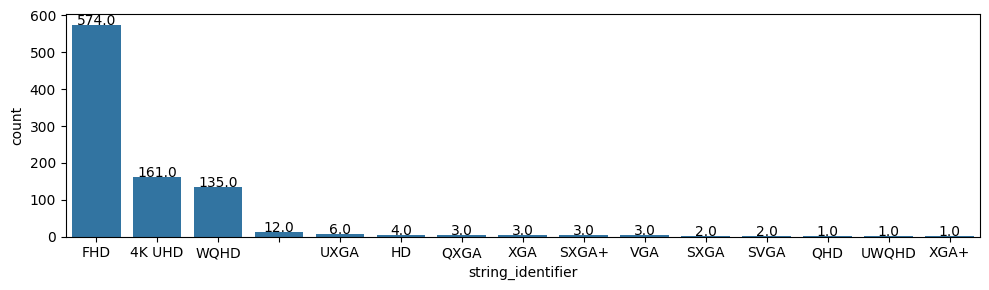

In [47]:
# Barplots to show count of unique string identifiers identifying resolution in data
fig, ax = plt.subplots(figsize=(10, 3))
order = df['string_identifier'].value_counts().index
graph = sns.countplot(data=df, x='string_identifier', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
# _ = plt.xticks(rotation=80)
plt.tight_layout()

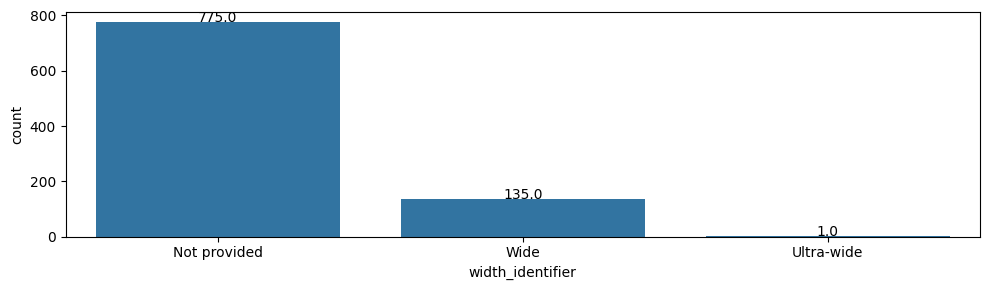

In [48]:
# Barplots to show count of different width identifiers in provided dataset
fig, ax = plt.subplots(figsize=(10, 3))
order = df['width_identifier'].value_counts().index
graph = sns.countplot(data=df, x='width_identifier', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
# _ = plt.xticks(rotation=80)
plt.tight_layout()

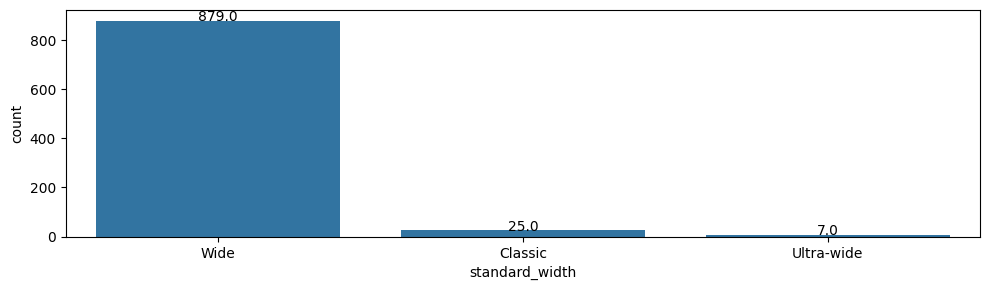

In [49]:
# Barplots to show count of different width identifiers we extracted from external data
fig, ax = plt.subplots(figsize=(10, 3))
order = df['standard_width'].value_counts().index
graph = sns.countplot(data=df, x='standard_width', order=order)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
# _ = plt.xticks(rotation=80)
plt.tight_layout()

## Multivariate analysis

### Bivariate analysis

<Axes: >

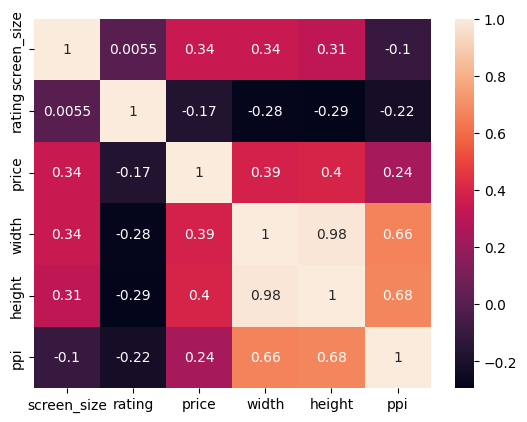

In [50]:
# Check correlation of screensize, resolution, aspect ratio, calculated ppi
sns.heatmap(df[numeric_cols].corr(), annot=True)

Width and height are strongly and positively correlated, whereas other features don't show strong correlation

ppi is somewhat correlated to height and width of resolution ind inversely correlated with screen size which is in line with the equation used

----------------------------------------------------

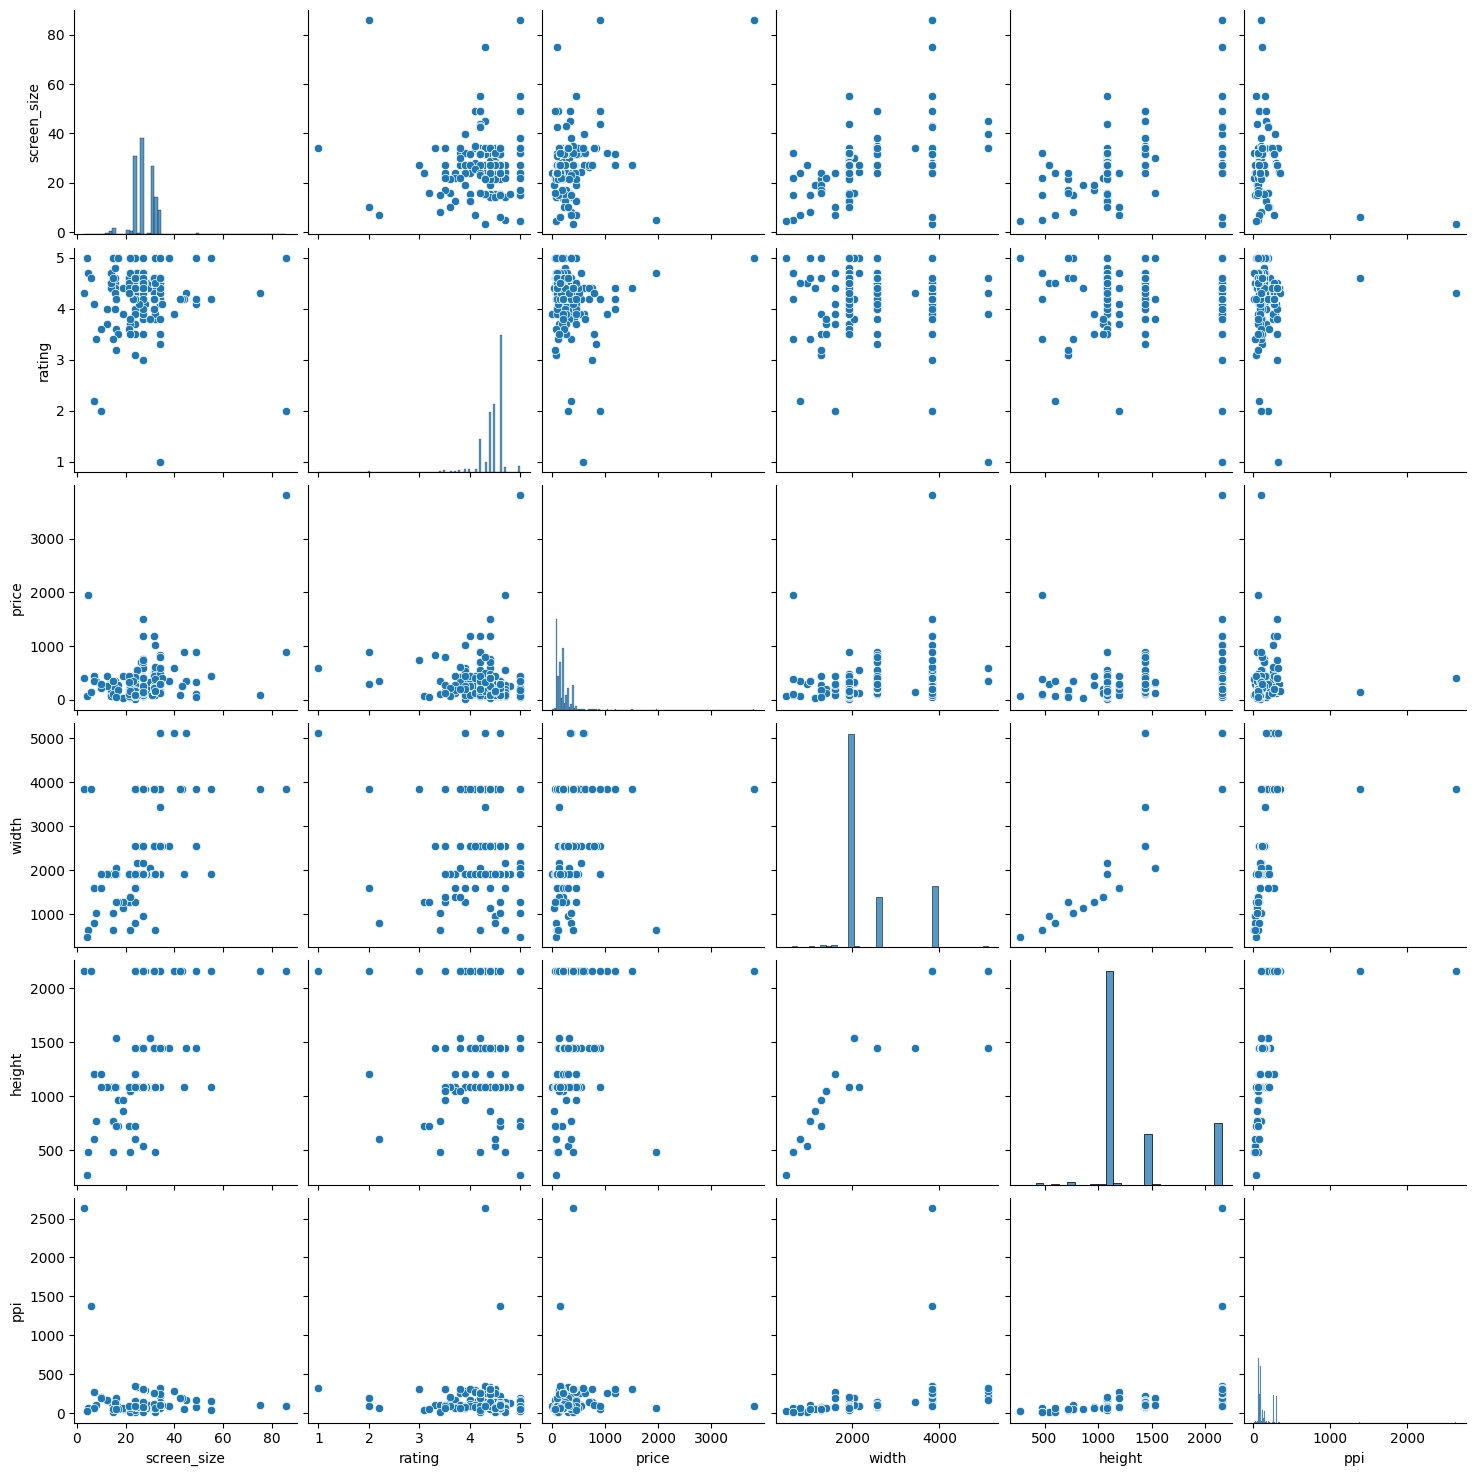

In [51]:
sns.pairplot(df[numeric_cols])

<Axes: xlabel='price', ylabel='brand'>

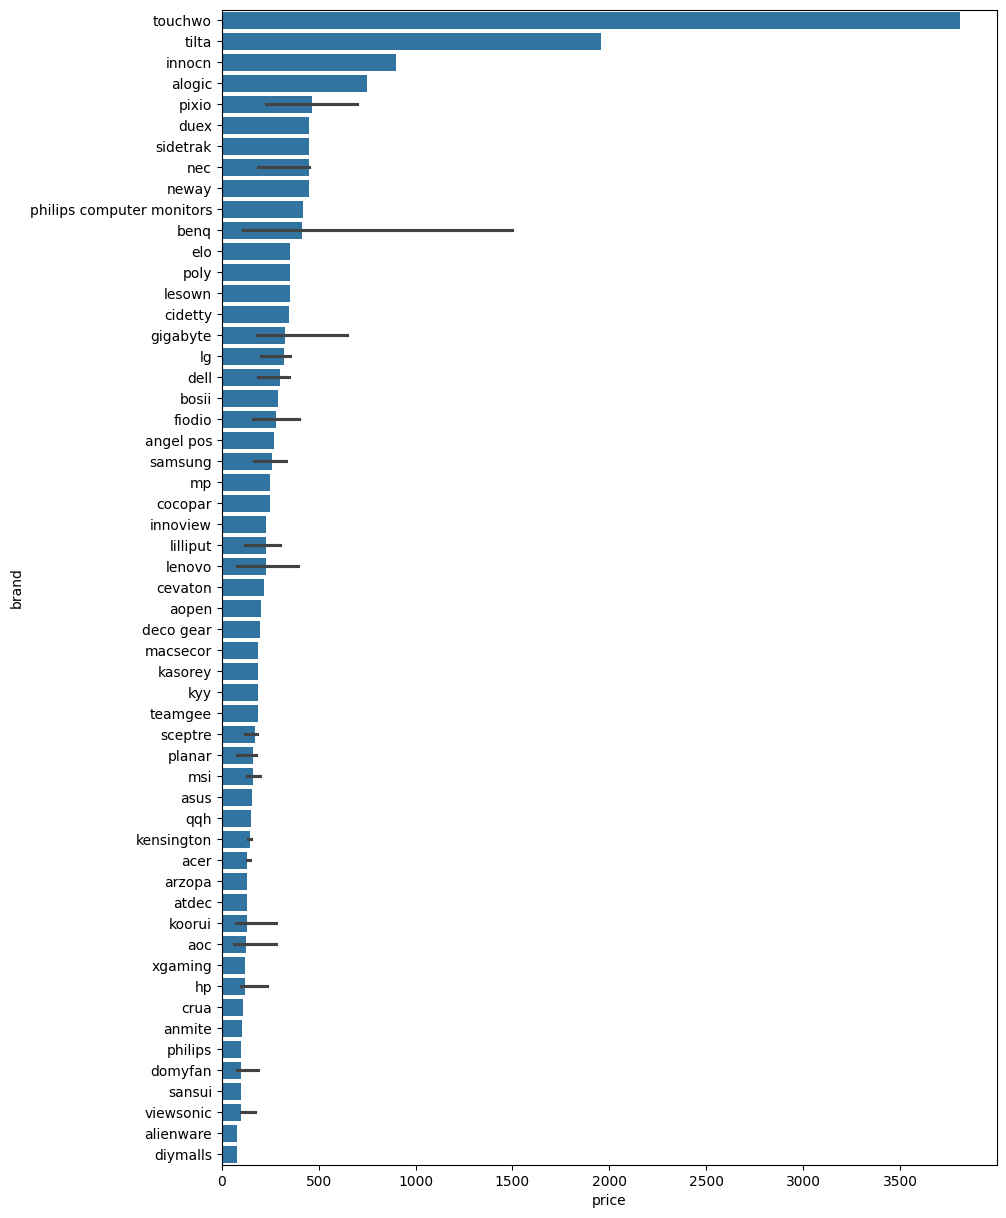

In [52]:
# Check brand-median price correlation for similar monitors
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(data=df, y='brand', x='price', estimator=np.median,
            order=df.groupby('brand')['price'].median().sort_values(ascending=False).index,
)

From the above bar plot, we can see that touchwo has the costliest monitor and

benq has a very high standard deviation. However, this high standard deviation can be because we don't have much recorded data

----------------------------------------------------

In [53]:
# We create a column for brand with only majorly present brands
value_count = df["brand"].value_counts()
df["brand_major"] = df["brand"].apply(lambda x: x if value_count.get(x, 0) > 5 else "Other")

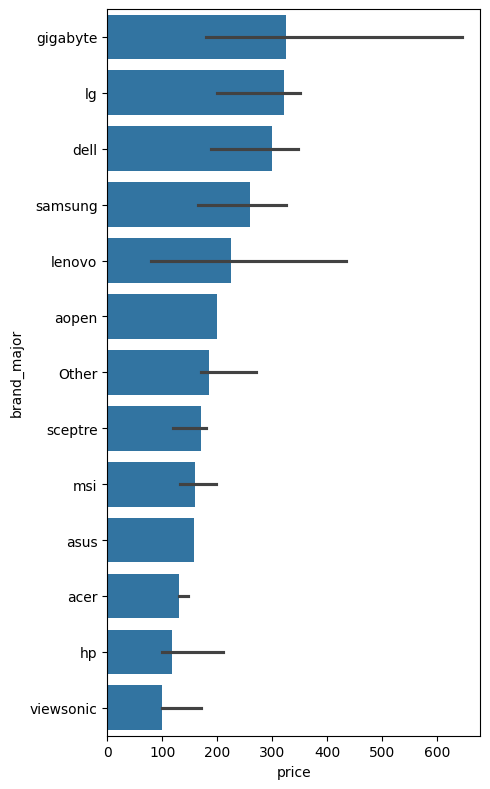

In [54]:
# Check major brands-median price correlation for similar monitors
fig, ax = plt.subplots(figsize=(5, 8))
sns.barplot(data=df, y='brand_major', x='price', estimator=np.median,
            order=df.groupby('brand_major')['price'].median().sort_values(ascending=False).index,
)
plt.tight_layout()

<Axes: xlabel='price', ylabel='brand_major'>

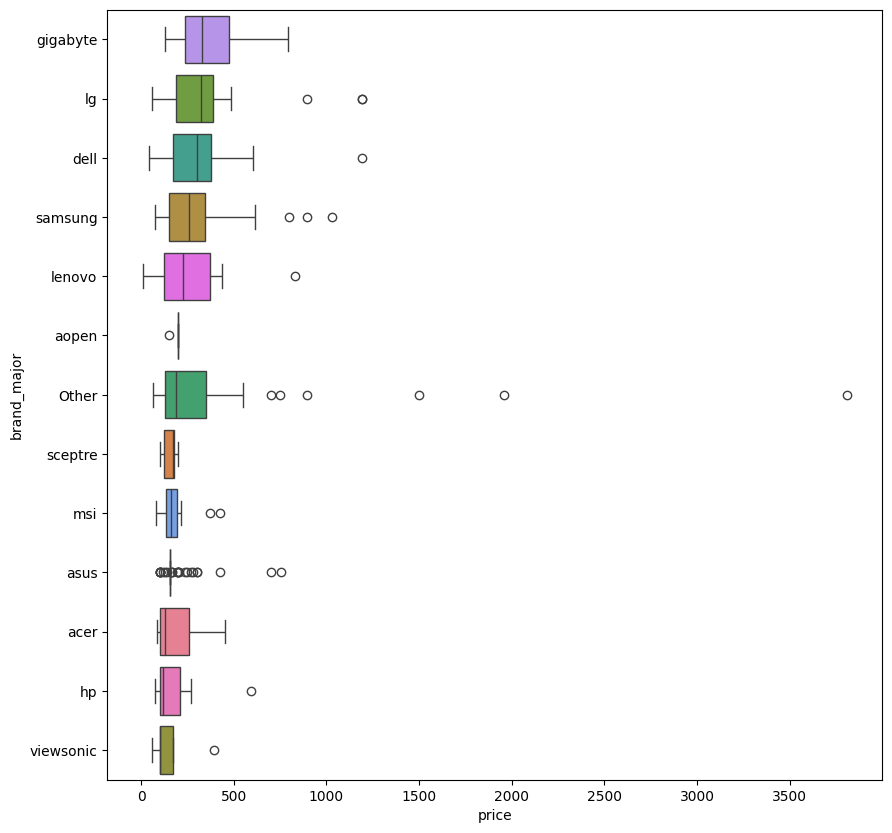

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
order = df.groupby('brand_major')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='price', y='brand_major', hue="brand_major", order=order) # Changed hue to y to fix the error

From the above plot, we can see that gigabyte has the highest median price and
acer, one of the most recorded monitor has almost 70% of the monitors cheaper than gigabyte's median

Asus, the 2nd most recorded brand in our data has a very low IQR and most of it's prices look like outliers

This means Asus' pricing shows a very high variability

----------------------------------------------------

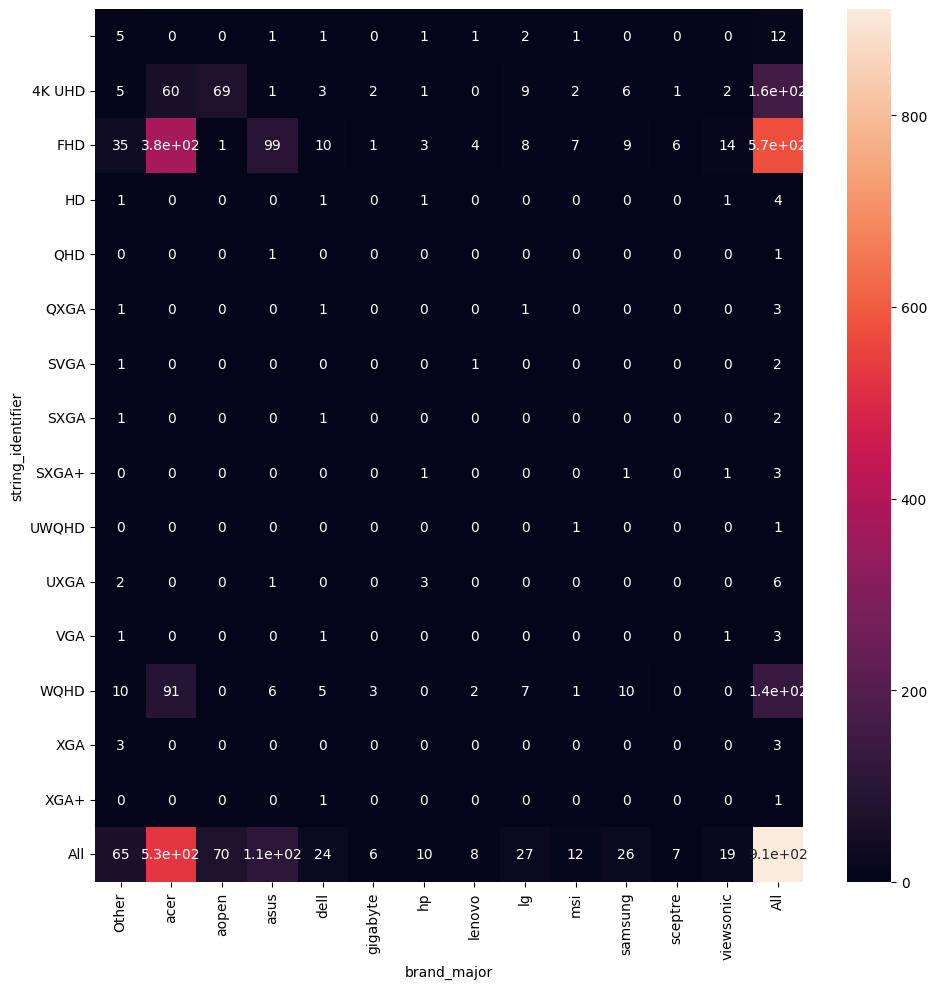

In [56]:
# Contingency tables and heatmaps
contingency_table = pd.crosstab(
    df["string_identifier"], df['brand_major'], margins=True,
    values=df['brand_major'], aggfunc=pd.Series.count)
# For non-existing combination of values, set them as 0
contingency_table = contingency_table.fillna(0)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(contingency_table.astype(int), annot=True)
plt.tight_layout()
plt.show()

In [57]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Statistic:", chi2)
print("P-value:", p, "=>", "Significant correlation" if p < 0.05 else "correlated by chance")
print("Degrees of Freedom:", dof)


Chi-Square Test Statistic: 1015.5907773404901
P-value: 4.659306150798845e-111 => Significant correlation
Degrees of Freedom: 195


High correlation between brand name and display type indicates that many brands sell only few segments of displays

--------------------------------------------

### Multivariate analysis

(with more than 2 features or comparing 2 features across different groups)

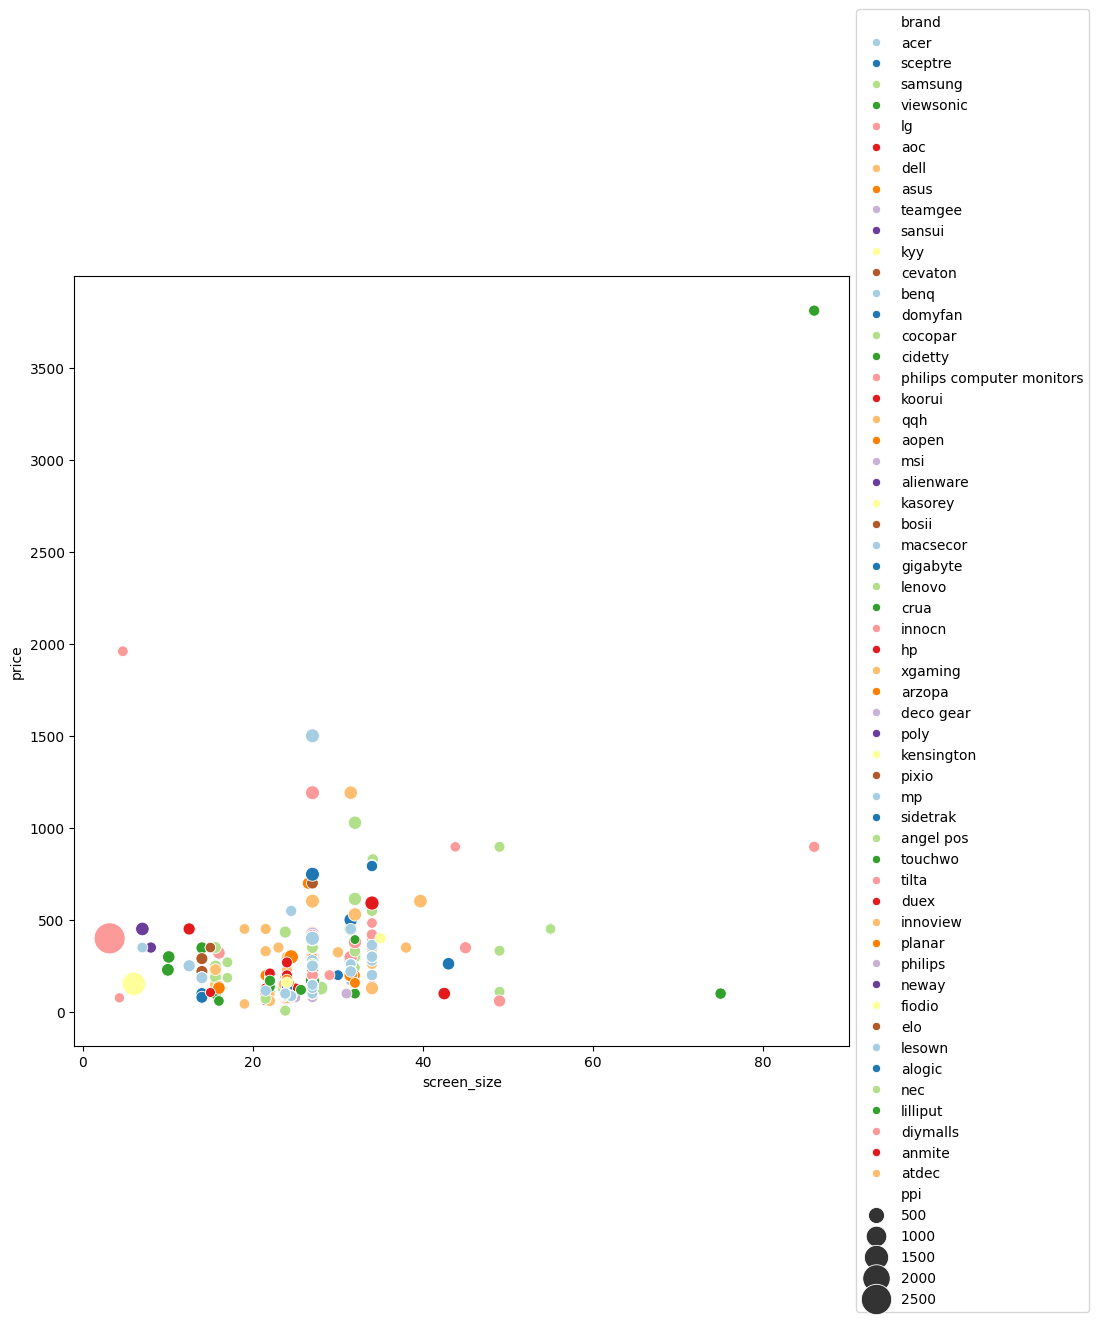

In [58]:
# Check size - price correlation
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.scatterplot(
    data=df, x='screen_size', y='price', hue='brand', size='ppi',
    sizes=(50, 500), palette=sns.color_palette("Paired", df["brand"].nunique()))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

We can see maximum price for a screen size going higher with increase in screen size

There are only 2 samples with >80 inch size and one of them is priced the highest in the dataset

Two bubbles are bigger than others indicating very high ppi but they are among the lowest priced and have very small size

----------------------------------------------------

In [59]:
df[df["screen_size"] > 80]

,title,brand,screen_size,resolution,aspect_ratio,rating,price,standard_aspect_ratio,width,height,string_identifier,precise_aspect_ratio,standard_width,width_identifier,ppi,brand_major
426,"86"" Touchscreen Monitor Smart Board, 4K Intera...",touchwo,86.0,4K UHD 2160p,16:9,5.0,3809.00,16:9,3840,2160,4K UHD,16:9,Wide,Not provided,96,Other
921,"LG 86UH5E-B Digital Signage Display - 86"" LCD ...",lg,86.0,4K UHD 2160p,16:9,2.0,896.99,16:9,3840,2160,4K UHD,16:9,Wide,Not provided,96,lg


Touchwo and LG both produce monitors with same attributes but LG is significantly cheaper

----------------------------------------------------

In [60]:
df[df["ppi"] > 1000]

,title,brand,screen_size,resolution,aspect_ratio,rating,price,standard_aspect_ratio,width,height,string_identifier,precise_aspect_ratio,standard_width,width_identifier,ppi,brand_major
158,LG UltraFine 31.5-Inch Computer Monitor 32UP83...,lg,3.15,4K UHD 2160p,16:9,4.3,399.99,16:9,3840,2160,4K UHD,16:9,Wide,Not provided,2633,lg
905,Kensington SmartFit Ergonomic Dual Monitor Piv...,kensington,6.00,4K DCI 2160p,16:9,4.6,152.55,16:9,3840,2160,,16:9,Wide,Not provided,1382,Other


In [61]:
print(df[df["ppi"] > 1000].title.values)

['LG UltraFine 31.5-Inch Computer Monitor 32UP83A-W, IPS with HDR 10 Compatibility and AMD FreeSync, White'
 'Kensington SmartFit Ergonomic Dual Monitor Pivoting Arm Mount (K60273WW)']



Both monitors with very high PPI have very small screen size

From the title we can see that the first value is a typing error and the screen is actually 31.5 inch instead of 3.15
The second product is actually a 6inch monitor mount, hence should be removed (https://www.amazon.com/Kensington-SmartFit-Ergonomic-Pivoting-K60273WW/dp/B01IVFEILW?th=1)

----------------------------------------------------

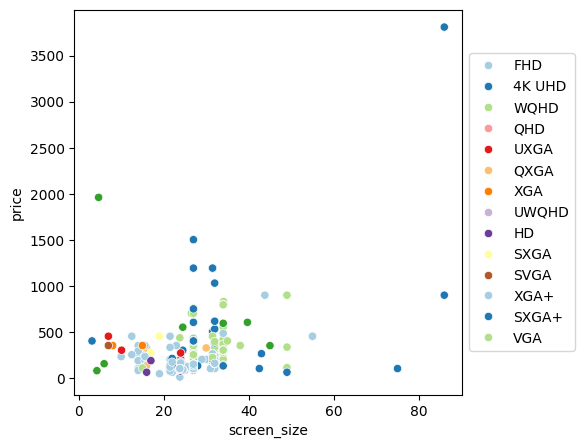

In [62]:
# Check size - price correlation
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.scatterplot(data=df, x='screen_size', y='price', hue='string_identifier',
    sizes=(50, 500), palette=sns.color_palette("Paired", df["string_identifier"].nunique()))
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [63]:
# Compare ratings for each major brand
fig = go.Figure()

df_max_rating = df.groupby("brand_major")["rating"].max().reset_index()
df_min_rating = df.groupby("brand_major")["rating"].min().reset_index()
df_mean_rating = df.groupby("brand_major")["rating"].mean().reset_index()

fig.add_trace(go.Scatterpolar(
      r=df_max_rating['rating'], theta=df_max_rating['brand_major'].values,
      fill='toself',
      name='Max rating'
))
fig.add_trace(go.Scatterpolar(
      r=df_mean_rating['rating'], theta=df_mean_rating['brand_major'],
      fill='toself',
      name='min rating'
))
fig.add_trace(go.Scatterpolar(
      r=df_min_rating['rating'], theta=df_min_rating['brand_major'],
      fill='toself',
      name='min rating'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=(1, 5)
    )),
  showlegend=False
)

fig.show()

All brands have good max and average ratings

HP, LG and some other brands have very low ratings as well

----------------------------------------------------

In [64]:
# Compare price per monitor width identifier
fig = go.Figure()

df_max_price = df.groupby("standard_width")["price"].max().reset_index()
df_mean_price = df.groupby("standard_width")["price"].mean().reset_index()

fig.add_trace(go.Scatterpolar(
      r=df_max_price['price'], theta=df_max_price['standard_width'].values,
      fill='toself',
      name='Max Price'
))
fig.add_trace(go.Scatterpolar(
      r=df_mean_price['price'], theta=df_mean_price['standard_width'],
      fill='toself',
      name='Mean Price'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=(df_mean_price['price'].min(), df_max_price['price'].max())
    )),
  showlegend=False
)

fig.show()

Max values for each are too large compared to mean

----------------------------------------------------

In [65]:
# Compare percentage of price difference across each monitor width category
import plotly.graph_objects as go
fig = go.Figure()

df_max_price = df.groupby("standard_width")["price"].max().reset_index()
df_mean_price = df.groupby("standard_width")["price"].mean().reset_index()
df_median_price = df.groupby("standard_width")["price"].median().reset_index()

fig.add_trace(go.Scatterpolar(
      r=(df_max_price['price']/df_max_price['price'].max())*100,
      theta=df_max_price['standard_width'],
      fill='toself',
      name='Max Price'
))
fig.add_trace(go.Scatterpolar(
      r=(df_mean_price['price']/df_mean_price['price'].max())*100,
      theta=df_mean_price['standard_width'],
      fill='toself',
      name='Mean Price'
))
fig.add_trace(go.Scatterpolar(
      r=(df_median_price['price']/df_median_price['price'].max())*100,
      theta=df_median_price['standard_width'],
      fill='toself',
      name='Mean Price'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=(0, 100)
    )),
  showlegend=True
)
fig.show()

Max price of classic monitor is 3/5th of that of wide monitor and ultra wide monitor

Mean and median prices are almost same and wide is 2/5th of ultra-wide and classic is 4/5th of ultrawide

----------------------------------------------------

----------------------------------------------------

Overall, the data tells us about the different atributes of monitors, the brands producing them, how the brands are rated, which brands have bad ratings.
-----

We can see that the screen size or pixel density is not a big factor in pricing but different brands operate in slightly different price ranges, with some costing significantly higher than other for similar product.
-----

A lot of brands produce products of a wide range and hence have high variability in pricing.
-----

PS: Conclusion from plos/tests are mentioned under the corresponding cell.

----------------------------------------------------